In [ ]:
!pip install jiwer pytesseract paddlepaddle paddleocr transformers

In [113]:
import cv2
from PIL import Image, ImageFont, ImageDraw
import torch
import numpy as np
from jiwer import wer, cer
import matplotlib.pyplot as plt
from datetime import datetime

import easyocr
import pytesseract
import paddle
from paddleocr import PaddleOCR
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


if torch.backends.mps.is_available():
    device = torch.device("mps")

In [110]:
# class Recognitor(EasyocrRecognitor):
#     def __init__(self, ):
#         self.model = 

#     def recognite(self, image):
    
#         # ["str", "str"], [[xyxy], [xyxy]]
#         return words, boxes

In [11]:
class EasyocrRecognitor:
    def __init__(self,):
        self.model = easyocr.Reader(['ru', 'en'], gpu=True)

        return

    def preprocessing(self, image):
        preprocessed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        return preprocessed_image
    
    def recognite(self, image):
        preprocessed_image = self.preprocessing(image)
        predictions = self.model.readtext(preprocessed_image)

        texts = []
        boxes = []
        for (bbox, text, confidence) in predictions:
            # print(f"Текст: {text}, Точность: {confidence:.2f}")
            xyxy = list(map(int, bbox[0])) + list(map(int, bbox[2]))

            texts.append(text)
            boxes.append(xyxy)

        return texts, boxes

In [73]:
class TesseractRecognitor:
    def __init__(self,):
        return 
    
    def preprocessing(self, image):

        # preprocessed_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        preprocessed_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return preprocessed_image
    
    def recognite(self, image):
        preprocessed_image = self.preprocessing(image)
        predictions = pytesseract.image_to_data(preprocessed_image, lang='rus+eng', output_type=pytesseract.Output.DICT)

        texts = []
        boxes = []
        for i in range(len(predictions['text'])):
            if predictions['text'][i].strip():

                x, y, w, h = predictions['left'][i], predictions['top'][i], predictions['width'][i], predictions['height'][i]
                texts.append(predictions['text'][i])
                boxes.append([x, y, x+w, y+h])
                # print(f"Текст: {predictions['text'][i]}")
        #         print(f"Координаты: (left={data['left'][i]}, top={data['top'][i]}, width={data['width'][i]}, height={data['height'][i]})")
        #         print(f"Уверенность: {data['conf'][i]}\n")

        return texts, boxes

In [103]:
class TrOCRRecognitor:
    def __init__(self,):
        self.processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
        self.model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
        return 
    
    def detect(self, image):
        predictions = pytesseract.image_to_data(image, lang='rus+eng', output_type=pytesseract.Output.DICT)

        detections = []
        for i in range(len(predictions['text'])):
            if predictions['text'][i].strip() and int(predictions['conf'][i]) > 60:  # Фильтр по уверенности
                x, y, w, h = predictions['left'][i], predictions['top'][i], predictions['width'][i], predictions['height'][i]
                # cropped = image[y:y+h, x:x+w]
                detections.append([x, y, x+w, y+h])
                
                # try:
                #     text = recognize_text(Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)))
                #     results.append({
                #         "text": text,
                #         "bbox": [x, y, x+w, y+h],
                #         "confidence": float(predictions['conf'][i])
                #     })

        return detections
    
    def preprocessing(self, image):

        # preprocessed_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        preprocessed_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return preprocessed_image
    
    
    def recognite(self, image):
        boxes = self.detect(image)

        texts = []
        for bbox in boxes:
            cropped = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
            try:
                pixel_values = self.processor(self.preprocessing(cropped), return_tensors="pt").pixel_values
                generated_ids = self.model.generate(pixel_values)
                text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

                texts.append(text)
            except:
                continue

        return texts, boxes

In [ ]:
# def recognize_text(image):
#     pixel_values = processor(image, return_tensors="pt").pixel_values
#     generated_ids = model.generate(pixel_values)
#     return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# def detect_and_recognize(image_path):
#     image = cv2.imread(image_path)
#     data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    
#     results = []
#     for i in range(len(data['text'])):
#         if data['text'][i].strip() and int(data['conf'][i]) > 60:  # Фильтр по уверенности
#             x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
#             cropped = image[y:y+h, x:x+w]
            
#             try:
#                 text = recognize_text(Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)))
#                 results.append({
#                     "text": text,
#                     "bbox": [x, y, x+w, y+h],
#                     "confidence": float(data['conf'][i])
#                 })
#             except Exception as e:
#                 print(f"Ошибка распознавания блока {i}: {str(e)}")
    
#     return results

# results = detect_and_recognize("ocr/shkolin dl 1.jpg")
# for item in results:
#     print(f"Текст: {item['text']}, BBox: {item['bbox']}, Уверенность: {item['confidence']:.1f}")

In [95]:
references = {
    "shkolin dl 1.jpg":
    [
        "ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕ",
        "PERMIS DE CONDUIRE",
        "DRIVING LICENCE",
        "1.ШКОЛИН",
        "SHKOLIN",
        "2.АЛЕКСАНДР ЮРЬЕВИЧ",
        "ALEKSANDR UR`EVICH",
        "3.11.03.2002",
        "ГОР.РЯЗАНЬ",
        "GOR.RIAZAN`",
        "4a)22.10.2022 4b)22.10.2032",
        "4c)ГИБДД 4777",
        "GIBDD 4777",
        "5.99 29 204744",
        "8.РЯЗАНСКАЯ ОБЛ.",
        "RIAZANSKAIA OBL.",
        "6.",
        "9.B B1 M",
        "7."
    ],
    "makoveeva dl 1.jpg":
    [
        "ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕ",
        "PERMIS DE CONDUIRE",
        "DRIVING LICENCE",
        "1.МАКОВЕЕВА",
        "MAKOVEEVA",
        "2.ПОЛИНА ЕВГЕНЬЕВНА",
        "POLINA EVGEN`EVNA",
        "3.26.02.2001",
        "Г.ЕКАТЕРИНБУРГ",
        "G.EKATERINBURG",
        "4a)10.07.2023 4b)10.07.2033",
        "4c)ГИБДД 7816",
        "GIBDD 7816",
        "5.99 34 223214",
        "8.СВЕРДЛОВСКАЯ ОБЛ.",
        "SVERDLOVSKAIA OBL.",
        "6.",
        "9.B B1 M",
        "7."
    ],
    "isaev dl 1.jpg":
    [
        "ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕ",
        "PERMIS DE CONDUIRE",
        "DRIVING LICENCE",
        "1.ИСАЕВ",
        "ISAEV",
        "2.РОМАН ОЛЕГОВИЧ",
        "ROMAN OLEGOVISH",
        "3.22.06.2001",
        "САМАРСКАЯ ОБЛ.",
        "SAMARSKAIA OBL.",
        "4a)24.06.2019 4b)24.06.2029",
        "4c)ГИБДД 6360",
        "GIBDD 7816",
        "5.99 08 409677",
        "8.САМАРСКАЯ ОБЛ.",
        "SAMARSKAIA OBL.",
        "6.",
        "9.B B1 M",
        "7."
    ],
    # "shkolin snils.jpg":
    # [
    #     "Российская Федерация",
    #     "СТРАХОВОЕ СВИДЕТЕЛЬСТВО",
    #     "ОБЯЗАТЕЛЬНОГО ПЕНСИОННОГО СТРАХОВАНИЯ",
    #     "196-937-973 62",
    #     "Ф.И.О.ШКОЛИН",
    #     "АЛЕКСАНДР",
    #     "ЮРЬЕВИЧ",
    #     "Дата и место рождения11.03.2002",
    #     "РЯЗАНЬ",
    #     "РЯЗАНСКАЯ ОБЛАСТЬ",
    #     "ПолМужской",
    #     "Дата регистрации10.01.2017"
    # ],
    # "shkolin card.jpg":
    # [
    #     "МУЛЬТИКАРТА",
    #     "ВТБ",
    #     "2200 2407 2324 6605",
    #     "VALIDTHRU08/22",
    #     "ALEKSANDR SHKOLIN",
    #     "МИР",
    #     "PM-PU"
    # ]
}



In [110]:
algos = [EasyocrRecognitor, TesseractRecognitor, TrOCRRecognitor]

performance_metrics = []
inference_metrics = []

for algo in algos:
    model = algo()
    model_performance_metrics = []
    model_inference_metrics = []

    for path, reference in references.items():
        image = cv2.imread(f'ocr/{path}')

        start_time = datetime.now()
        preds, boxes = model.recognite(image)
        end_time = datetime.now()

        reference = "".join(reference)
        prediction = "".join(preds)

        print(reference)
        print(prediction)

        model_performance_metrics.append(cer(reference, prediction))
        model_inference_metrics.append((end_time - start_time).total_seconds())

    performance_metrics.append(model_performance_metrics)
    inference_metrics.append(model_inference_metrics)

ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕPERMIS DE CONDUIREDRIVING LICENCE1.ШКОЛИНSHKOLIN2.АЛЕКСАНДР ЮРЬЕВИЧALEKSANDR UR`EVICH3.11.03.2002ГОР.РЯЗАНЬGOR.RIAZAN`4a)22.10.2022 4b)22.10.20324c)ГИБДД 4777GIBDD 47775.99 29 2047448.РЯЗАНСКАЯ ОБЛ.RIAZANSKAIA OBL.6.9.B B1 M7.
ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕ6USPERMIS DE CONDUIREDRIVING LICENCE1ШКОЛИНSHKOLIN2АЛЕКСАНДР ЮРЬЕВИЧALEKSANDR UR'EVICH311.03.2002ГОР: РЯЗАНЬGOR  RIAZAN'4а)22.10.20224b)22.10.20324с)ГИБДД 4777GIBDD 4777599 29 2047448+РЯЗАНСКАЯ ОБЛ:RIAZANSKAIA OBL:6.L_9ВB1M7
ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕPERMIS DE CONDUIREDRIVING LICENCE1.МАКОВЕЕВАMAKOVEEVA2.ПОЛИНА ЕВГЕНЬЕВНАPOLINA EVGEN`EVNA3.26.02.2001Г.ЕКАТЕРИНБУРГG.EKATERINBURG4a)10.07.2023 4b)10.07.20334c)ГИБДД 7816GIBDD 78165.99 34 2232148.СВЕРДЛОВСКАЯ ОБЛ.SVERDLOVSKAIA OBL.6.9.B B1 M7.
ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕRUSPERMIS DE CONDUIREDHIVING LICENCEМАКОВЕЕВАMAKOVEEVAПОЛИНА ЕВГЕНЬЕВНАPOLINA EVGENEVNA26-02.2001ТЕКАТЕРИНБУРГEKATERINBURGца)10.07.20234b) 10.07.20334с)61ВБВ7.81[781699 34 223214СВЕРДЛОВСКАЯ ОБЛ:SVERDL

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕPERMIS DE CONDUIREDRIVING LICENCE1.ШКОЛИНSHKOLIN2.АЛЕКСАНДР ЮРЬЕВИЧALEKSANDR UR`EVICH3.11.03.2002ГОР.РЯЗАНЬGOR.RIAZAN`4a)22.10.2022 4b)22.10.20324c)ГИБДД 4777GIBDD 47775.99 29 2047448.РЯЗАНСКАЯ ОБЛ.RIAZANSKAIA OBL.6.9.B B1 M7.
WWW.K.K.K.K.K.K.K.K.K:AMOUNT1.00XXX13AAX:62 G838:1SA$0.20:MAR:-WW0:8


The channel dimension is ambiguous. Got image shape (3, 16, 3). Assuming channels are the first dimension.


ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕPERMIS DE CONDUIREDRIVING LICENCE1.МАКОВЕЕВАMAKOVEEVA2.ПОЛИНА ЕВГЕНЬЕВНАPOLINA EVGEN`EVNA3.26.02.2001Г.ЕКАТЕРИНБУРГG.EKATERINBURG4a)10.07.2023 4b)10.07.20334c)ГИБДД 7816GIBDD 78165.99 34 2232148.СВЕРДЛОВСКАЯ ОБЛ.SVERDLOVSKAIA OBL.6.9.B B1 M7.
PL:7SR:1181K1::70.2520MEN1SR%
ВОДИТЕЛЬСКОЕ УДОСТОВЕРЕНИЕPERMIS DE CONDUIREDRIVING LICENCE1.ИСАЕВISAEV2.РОМАН ОЛЕГОВИЧROMAN OLEGOVISH3.22.06.2001САМАРСКАЯ ОБЛ.SAMARSKAIA OBL.4a)24.06.2019 4b)24.06.20294c)ГИБДД 6360GIBDD 78165.99 08 4096778.САМАРСКАЯ ОБЛ.SAMARSKAIA OBL.6.9.B B1 M7.
1.50:1X:1)1::


In [111]:
print(performance_metrics)
print(inference_metrics)

[[0.0992063492063492, 0.19402985074626866, 0.204], [0.38492063492063494, 0.4664179104477612, 0.68], [0.9166666666666666, 0.9440298507462687, 0.972]]
[[0.601951, 0.282653, 0.317223], [0.55188, 0.296033, 0.248264], [17.231998, 10.213308, 5.908531]]


In [112]:
print(np.mean(performance_metrics, axis=1))
print(np.mean(inference_metrics, axis=1))

[0.1657454  0.51044618 0.94423217]
[ 0.400609    0.36539233 11.11794567]


Текст: МУЛЬИКАРТА, Точность: 0.99
Текст: ВТБ, Точность: 1.00
Текст: eaUU, Точность: 0.15
Текст: 2407 2Ээц, Точность: 0.54
Текст: 6605, Точность: 0.25
Текст: VALID, Точность: 1.00
Текст: 08/22, Точность: 1.00
Текст: THRU, Точность: 0.99
Текст: ALEKSANDR, Точность: 0.83
Текст: SHKOLI I, Точность: 0.21
Текст: МИР, Точность: 0.94
Текст: 77=Pg, Точность: 0.40


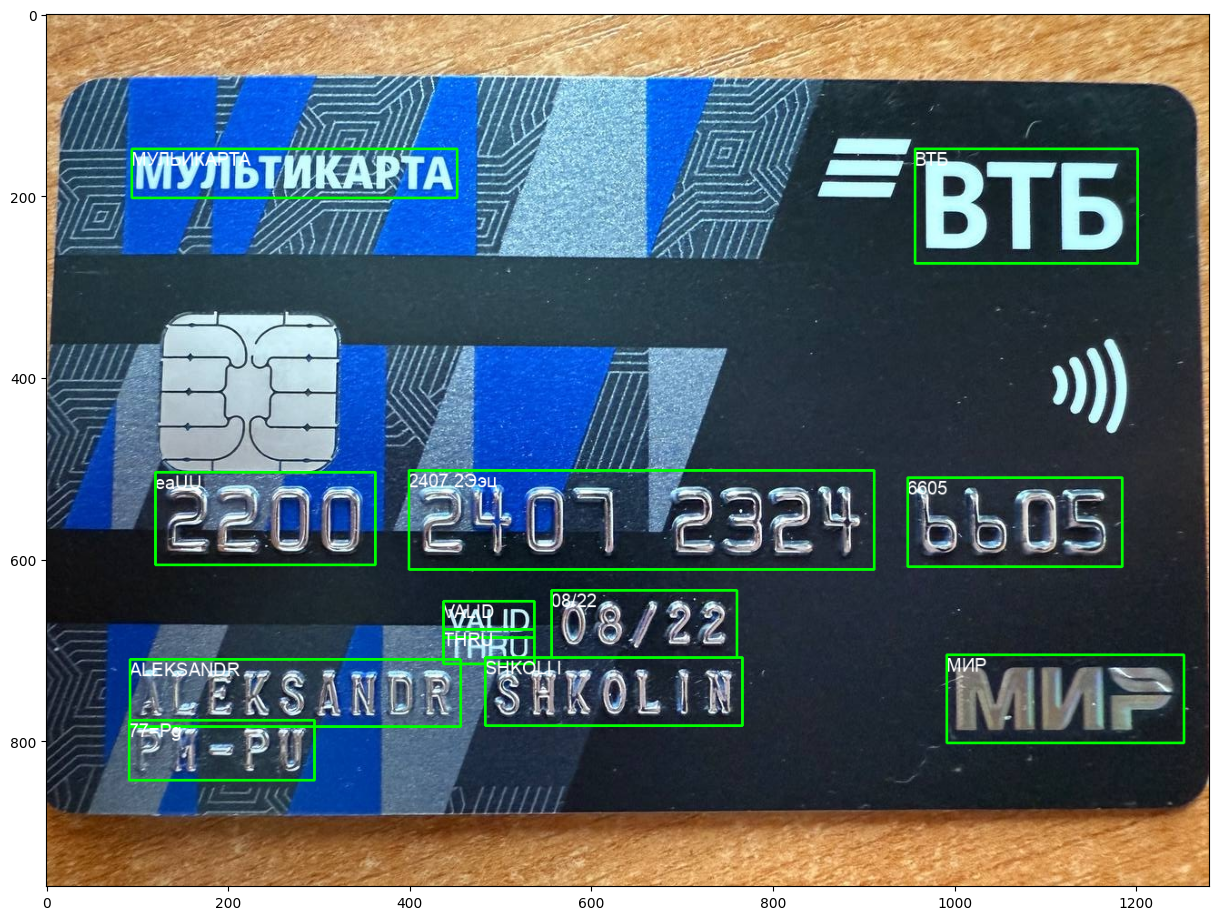

In [143]:
# Визуализация
name = "shkolin card.jpg"
image = cv2.imread(f'ocr/{name}')

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

reader = easyocr.Reader(['ru', 'en'], gpu=True)
predictions = reader.readtext(gray_image)

words = []
boxes = []
for (bbox, text, confidence) in predictions:
    print(f"Текст: {text}, Точность: {confidence:.2f}")
    xyxy = list(map(int, bbox[0])) + list(map(int, bbox[2]))

    words.append(text)
    boxes.append(xyxy)

    # Визуализация (опционально)
    top_left = tuple(map(int, bbox[0]))
    bottom_right = tuple(map(int, bbox[2]))
    
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)
    draw.text((top_left[0], top_left[1]), text, font=ImageFont.truetype("Arial.ttf", size=20))

    image = np.asarray(pil_image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    # cv2.putText(image, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

plt.figure(figsize = (15,15))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# result = [
#     {
#         "text": str,
#         "boxes": xyxy
#     }
# ]

# Прочее

In [144]:
def group_to_lines(words, boxes, threshold=30):
    lines = []
    current_line = []
    
    for i, (word, box) in enumerate(zip(words, boxes)):
        if not current_line:
            current_line.append((word, box))
        else:
            last_box = current_line[-1][1]
            if abs(box[1] - last_box[1]) < threshold:  # Проверка по Y-координате
                current_line.append((word, box))
            else:
                lines.append(current_line)
                current_line = [(word, box)]
    if current_line:
        lines.append(current_line)
    return lines

groups = group_to_lines(words, boxes)
for group in groups:
    print(" ".join([x[0] for x in group]))

МУЛЬИКАРТА ВТБ
eaUU 2407 2Ээц 6605
VALID 08/22
THRU
ALEKSANDR SHKOLI I МИР
77=Pg


In [94]:
# def normalize_bbox(bbox, image_size):
#     """Нормализует координаты bbox в диапазон 0-1000"""
#     width, height = image_size
#     return [
#         int(1000 * (bbox[0] / width)),
#         int(1000 * (bbox[1] / height)),
#         int(1000 * (bbox[2] / width)),
#         int(1000 * (bbox[3] / height)),
#     ]

In [95]:
# from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification, LayoutLMTokenizer
# from PIL import Image
# import torch

# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
# model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=5)  # 5 типов связей

In [96]:
# image = cv2.imread(f'Shkolin Dl 1.jpg')
# # image = cv2.imread(f'Shkolin DL 1.jpg')

# words, boxes = ocr(image)
# normalized_boxes = [normalize_bbox(box, image.shape[1::-1]) for box in boxes]

In [97]:
# encoding = processor(
#     image, 
#     words, 
#     boxes=normalized_boxes,
#     # return_offsets_mapping=True,
#     padding="max_length",
#     truncation=True,
#     max_length=512,
#     return_tensors="pt"
# )

In [98]:
# with torch.no_grad():
#     outputs = model(**encoding)
#     predictions = outputs.logits.argmax(-1).squeeze().tolist()

# # 7. Визуализация результатов
# for word, box, pred in zip(words, boxes, predictions[:len(words)]):
#     print(f"Текст: {word}, Координаты: {box}, Класс: {pred}")

In [99]:
# plt.figure(figsize=(12, 8))
# plt.imshow(image)

# colors = ['red', 'blue', 'green', 'purple', 'orange']  # Для разных типов связей

# for (x1, y1, x2, y2), word, pred in zip(boxes, words, predictions[:len(boxes)]):
#     plt.gca().add_patch(plt.Rectangle(
#         (x1, y1), x2-x1, y2-y1,
#         fill=False,
#         edgecolor=colors[pred],
#         linewidth=2
#     ))
#     plt.text(x1, y1-10, f"{word} ({pred})", fontsize=8, color=colors[pred])

# plt.axis('off')
# plt.show()

In [ ]:
# for item in labels:
#     image = cv2.imread(f'Documents-OCR-Detection-1/test/images/{item["name"]}.jpg')

#     model = EasyocrRecognitor()
#     preds, boxes = model.recognite(image)

#     iou = box_iou(torch.tensor(np.array(item["xyxy"])), torch.tensor(np.array(boxes))).numpy().max(axis=1).mean()
#     print(iou)